In [117]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import imageio
from PIL import Image, ImageEnhance
import mahotas as mt
import sklearn

In [2]:
from test2 import get_descriptors, apply_mask
from morph_texture import normalize

In [3]:
R, G, B = 0, 1, 2
H, W, CH = 0, 1, 2

In [4]:
img = imageio.imread('./test_img.png')
im = Image.open('./test_img.png')

In [5]:
def show(img, plt_size=(16, 10), cmap=None):
    fig = plt.figure(figsize=plt_size)
    plt.imshow(img, cmap=cmap if cmap is not None else (None if len(img.shape) == 3 else 'gray'))

In [ ]:
small = cv2.resize(img, (img.shape[W] // 4, img.shape[H] // 4))

In [ ]:
show(small)

In [ ]:
hsv = cv2.cvtColor(normalize(img, type=np.float32), cv2.COLOR_RGB2HSV)

In [ ]:
h = hsv[:,:,0]

In [ ]:
np.mean(h), np.std(h)
low = np.mean(h) - 3 * np.std(h)
high = np.mean(h) + 3 * np.std(h)

h = np.clip(h, low, high)

In [ ]:

h = normalize(h - np.mean(h), (90, 180), h.dtype)
hsv[:, :, 0] = h

In [ ]:
show(cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB))

In [ ]:
lab = cv2.cvtColor(normalize(img, type=np.float32), cv2.COLOR_RGB2LAB)

b = normalize(lab[:, :, 2], (0, 255), np.uint8)




In [6]:
_, bin_img = cv2.threshold(b, 100, 1, cv2.THRESH_BINARY)

NameError: name 'b' is not defined

In [ ]:
show(bin_img)

In [ ]:
reg2.shape

In [7]:
mean_px = np.mean(img, axis=(0,1))

In [8]:
img = img.astype(np.float64)


In [9]:
reg = normalize(img - mean_px, (0, 255), np.uint8)

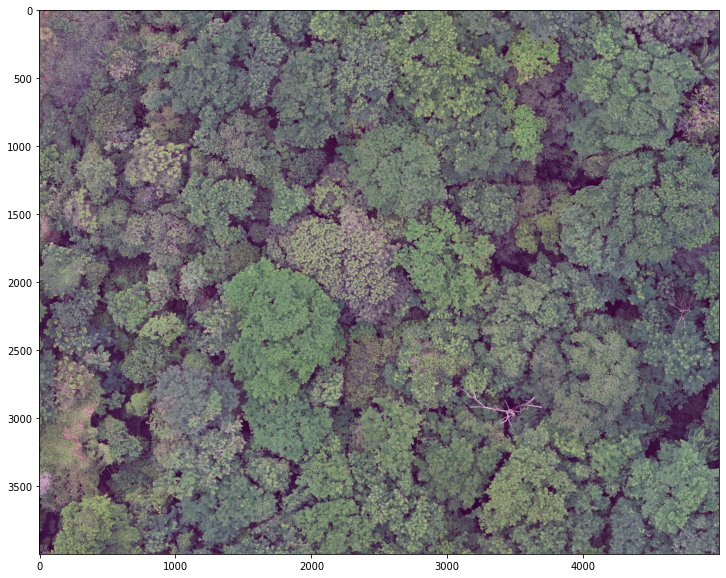

In [10]:
show(reg)

In [11]:
enh = ImageEnhance.Contrast(Image.fromarray(reg))

In [12]:
highcontrast = enh.enhance(2.5)

In [13]:
hc = np.asarray(highcontrast)

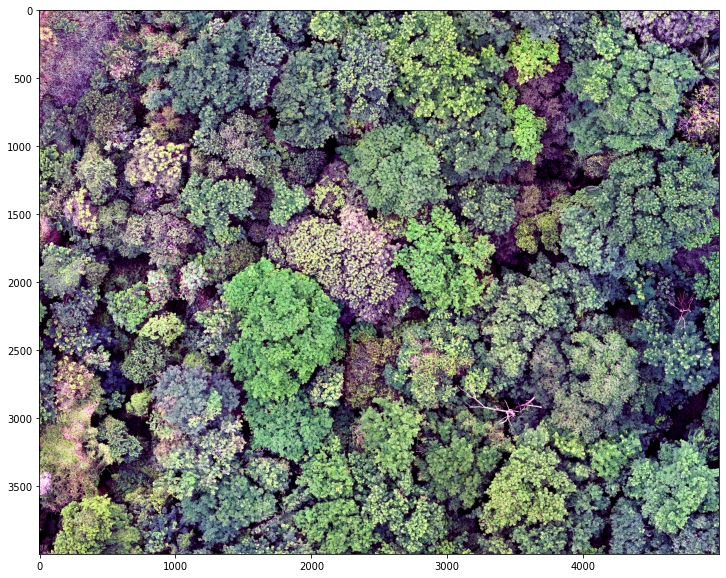

In [14]:
show(hc)

0 255
False


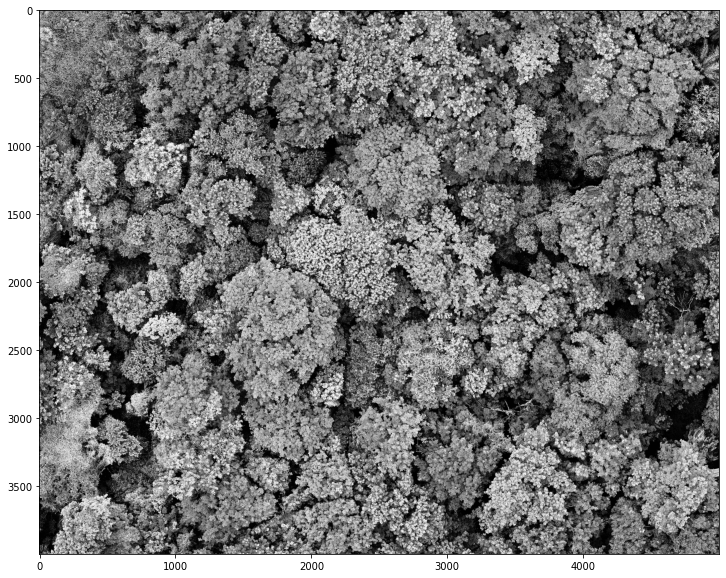

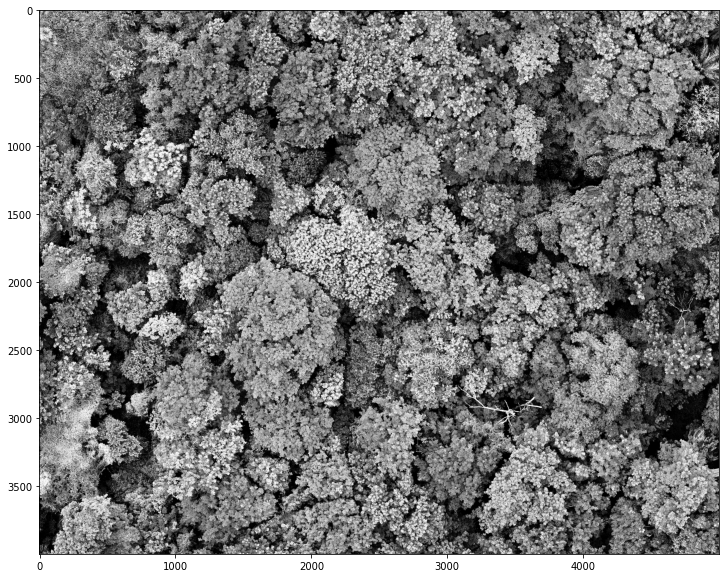

In [177]:
adpt = cv2.adaptiveThreshold(gray_img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 15, 5)
print(np.min(adpt), np.max(adpt))
print(np.all(gray_img - adpt == gray_img))
show(gray_img - adpt)
show(gray_img)

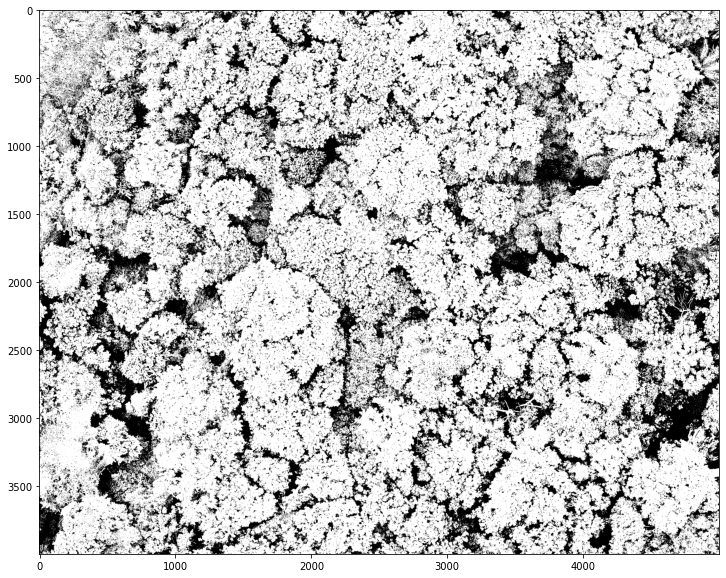

In [51]:
factor = 0.5
gray_img = cv2.cvtColor(hc, cv2.COLOR_RGB2GRAY)
thresh, bin_img = cv2.threshold(gray_img, 80, 1, cv2.THRESH_OTSU)
_, bin_img = cv2.threshold(gray_img, int(thresh * factor), 1, cv2.THRESH_BINARY)
show(bin_img)

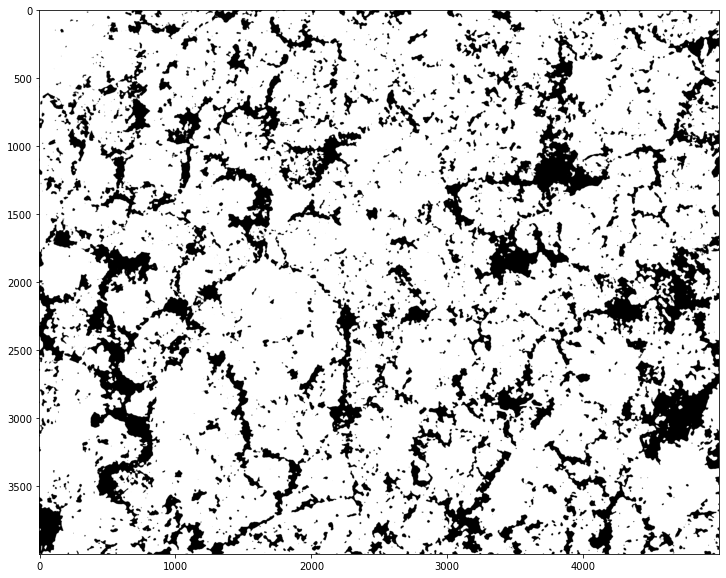

In [55]:
bin_blur = cv2.medianBlur(bin_img, 17)
show(bin_blur)

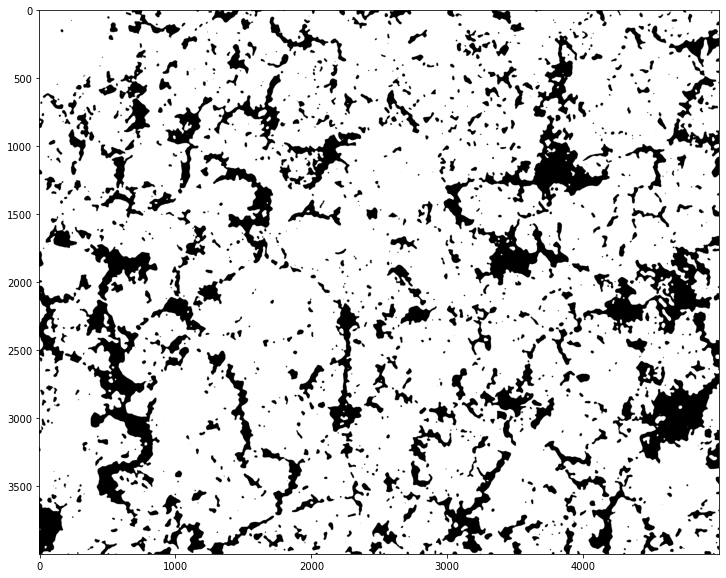

In [57]:
s = 7
p = 4
kernel = np.zeros((s, s))
kernel = np.pad(kernel, p, 'constant', constant_values=(1))
kernel /= np.sum(kernel)
clean = cv2.filter2D(bin_blur, -1, kernel)
show(clean)

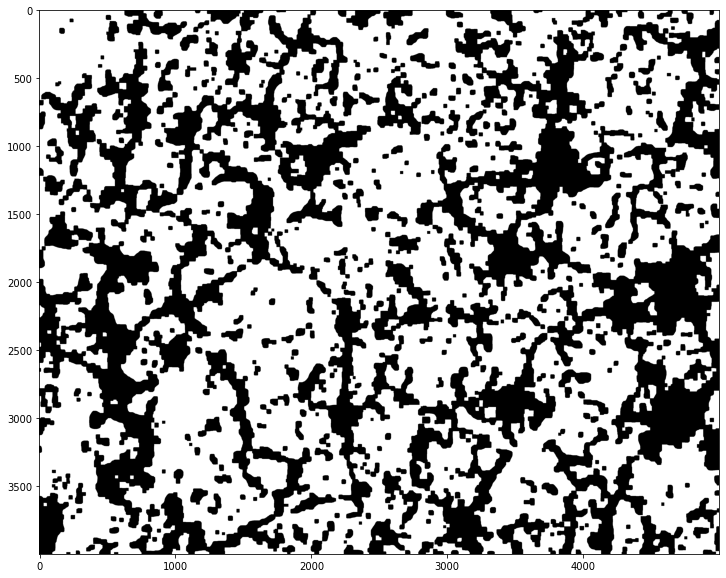

In [113]:
morph = cv2.morphologyEx(clean, cv2.MORPH_OPEN, np.array([[1, 1, 1], [1, 1, 1], [1, 1, 1]]), iterations=20)
morph = cv2.morphologyEx(morph, cv2.MORPH_ERODE, np.array([[1, 1, 1], [1, 1, 1], [1, 1, 1]]), iterations=10)

show(morph)

In [118]:
import skimage

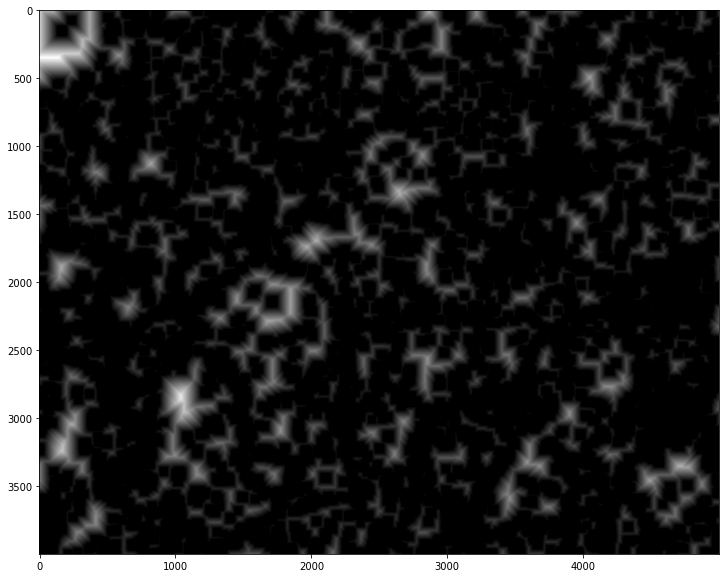

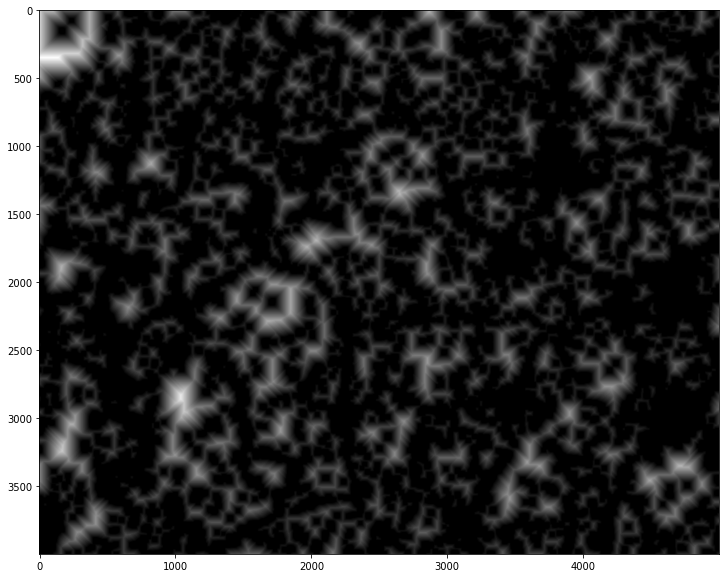

In [165]:
dist = cv2.distanceTransform(morph, cv2.DIST_C, 0)
dist = normalize(dist, (0, 255), np.uint8)
show(np.clip(dist, 20, 255))
show(dist)


50.0


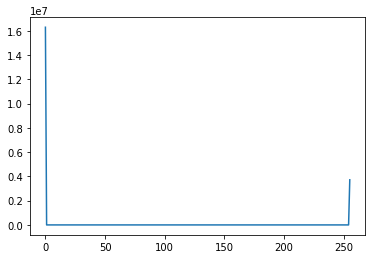

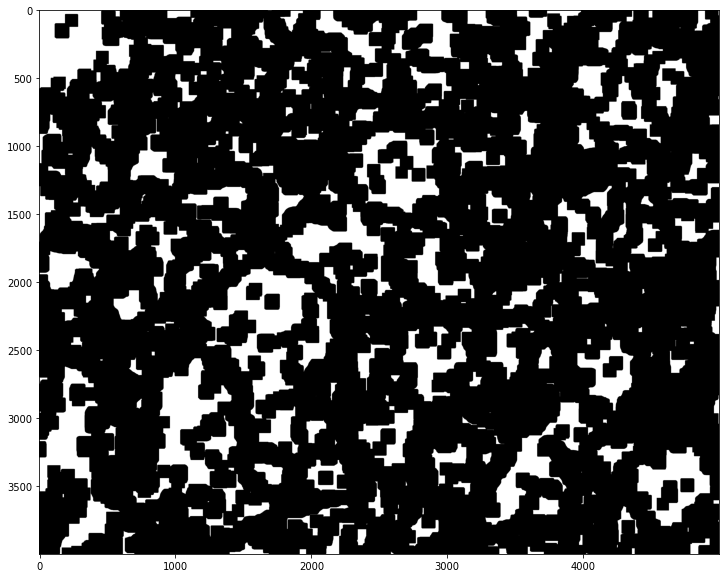

In [168]:
t, dist_t = cv2.threshold(dist, 50, 255, cv2.THRESH_BINARY)
#t, dist_t = cv2.threshold(dist_t, t, 255, cv2.THRESH_BINARY)

plt.plot(mt.histogram.fullhistogram(dist_t))
show(dist_t)
print(t)

In [78]:
_, markers = cv2.connectedComponents(dist)

error: OpenCV(4.5.5) /io/opencv/modules/imgproc/src/connectedcomponents.cpp:5632: error: (-215:Assertion failed) iDepth == CV_8U || iDepth == CV_8S in function 'connectedComponents_sub1'


In [ ]:
tst = cv2.morphologyEx(bin_blur, cv2.MORPH_DILATE, np.array([[1, 1, 1], [1, 1, 1], [1, 1, 1]]))
for i in range(2):
    tst = cv2.morphologyEx(tst, cv2.MORPH_ERODE, np.array([[1, 1, 1], [1, 1, 1], [1, 1, 1]]))

In [ ]:
show(tst)

In [ ]:
masked = np.zeros_like(hc)
idxs = np.where(tst == 1)
masked[idxs] = hc[idxs]

In [ ]:
show(masked)

In [ ]:
k_shp = (135, 135)
kernel = np.ones(k_shp, masked.dtype) / np.prod(k_shp)
filtered = cv2.filter2D(hc, -1, kernel)
filtered = cv2.filter2D(filtered, -1, kernel)
show(filtered)

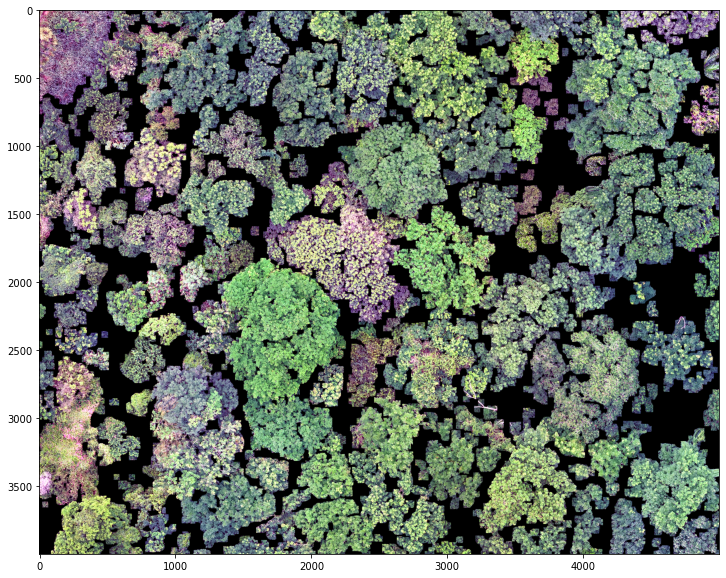

In [66]:
show(apply_mask(hc, morph))

In [ ]:
tolerance = 0.2
rel = masked.copy()


window = (50, 50)
for h in range(0, hc.shape[H], window[H]):
    for w in range(0, hc.shape[W], window[W]):
        crop = masked[h:min(h + window[H], masked.shape[H] - 1),
                      w:min(w + window[W], masked.shape[W] - 1)]
        blacks = np.where(np.all(crop == (0, 0, 0), axis=-1))
        if len(blacks[0]) / (crop.shape[H] * crop.shape[W]) > tolerance:
            rel[h:min(h + window[H], masked.shape[H] - 1),
                w:min(w + window[W], masked.shape[W] - 1)] = (180, 0, 180)
    

In [ ]:
show(rel)

In [ ]:
def describe_image(img, window, tolerance=0.2):
    result = []
    for h in range(0, hc.shape[H], window[H]):
        for w in range(0, hc.shape[W], window[W]):
            #print(h, w, img.shape[H], img.shape[W])
            crop = img[h:min(h + window[H], img.shape[H] - 1),
                        w:min(w + window[W], img.shape[W] - 1)]
            blacks = np.where(np.all(crop == (0, 0, 0), axis=-1))
            if len(blacks[0]) / (crop.shape[H] * crop.shape[W]) <= tolerance:
                result.append((h,
                               min(h + window[H], img.shape[H] - 1),
                               w,
                               min(w + window[W], img.shape[W] - 1),
                               get_descriptors(crop)))
    return result

In [ ]:
descr = describe_image(masked, (100, 100))

In [ ]:
descr.shape

In [ ]:
from sklearn.cluster import k_means

In [ ]:
cls = k_means([x[-1] for x in descr], 5)

In [ ]:
seg = np.zeros(hc.shape)

for i, cluster in enumerate(cls[1]):
    hh, ht, wh, wt = descr[i][:-1]
    seg[hh:ht, wh:wt] = cluster / 9

seg = normalize(seg, (0, 255), np.uint8)

In [ ]:
show(seg)

In [ ]:
k_means?

In [ ]:
ms = MeanShift()

In [ ]:
ms.fit(descr)

In [ ]:
ms.cluster_centers_